In [1]:
!apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [56.8 kB]
Hit:12 http://ppa.launchpad.net/cran/

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)
%cd '/content/gdrive/MyDrive/LDS9_ BigData'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS9_ BigData


In [3]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from pyspark.sql.functions import when, col, count, isnan, isnull, concat, lit,length,explode

In [5]:
#sc = SparkContext(master='local',appName='Ex4')
#spark = SparkSession(sc)

In [6]:
spark = SparkSession \
  .builder \
  .master("local[*]")\
  .appName("New-Spark") \
  .config("spark.memory.fraction", 0.8) \
  .config("spark.executor.memory", "4g") \
  .config("spark.driver.memory", "4g")\
  .config("spark.sql.shuffle.partitions" , "800") \
  .config("spark.memory.offHeap.enabled",'true')\
  .config("spark.memory.offHeap.size","4g")\
  .getOrCreate()
spark

## Data Exploring

In [7]:
df = pd.read_csv('./data/cbc-news-coronavirus-articles-march-26/news.csv')

In [8]:
data = spark.createDataFrame(df)

In [9]:
data.show(3)

+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|Unnamed: 0|             authors|               title|       publish_date|         description|                text|                 url|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
|         0|        ['Cbc News']|Coronavirus a 'wa...|2020-03-27 08:00:00|Canadian pharmaci...|Canadian pharmaci...|https://www.cbc.c...|
|         1|        ['Cbc News']|Yukon gov't names...|2020-03-27 01:45:00|The Yukon governm...|The Yukon governm...|https://www.cbc.c...|
|         2|['The Associated ...|U.S. Senate passe...|2020-03-26 05:13:00|The Senate has pa...|The Senate late W...|https://www.cbc.c...|
+----------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [10]:
data = data.drop('Unnamed: 0')

In [11]:
data.printSchema()

root
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- description: string (nullable = true)
 |-- text: string (nullable = true)
 |-- url: string (nullable = true)



In [12]:
data = data.select('text')

In [13]:
#Check mising value

In [14]:
data.select([count(when(isnan(col),col)).alias(col) for col in data.columns]).toPandas() #Nan

,text
0,0


In [15]:
data.select([count(when(isnull(col),col)).alias(col) for col in data.columns]).toPandas() #Null

,text
0,0


### Feature Transformation

In [16]:
from pyspark.ml.feature import RegexTokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [17]:
data = data.withColumn('length',length(col('text')))

In [18]:
tokenizer = RegexTokenizer(inputCol="text", outputCol="token_text", pattern='[^A-Za-z0-9]+',gaps=True)
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")

In [19]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

In [20]:
clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

### Pipeline


In [21]:
from pyspark.ml import Pipeline

In [22]:
data_prep_pipe = Pipeline(stages=[tokenizer,stopremove,count_vec,idf,clean_up])
#data_prep_pipe = Pipeline(stages=[tokenizer,stopremove,count_vec,idf])
cleaner = data_prep_pipe.fit(data)
clean_data = cleaner.transform(data)

### Train model and Evaluate

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [24]:
k_list = []
silhouette_list = []
#wsse_list = []
for k in range(2,9):
    kmeans = KMeans(k = k,seed=42)
    model = kmeans.fit(clean_data)
    predictions = model.transform(clean_data)
    #wsse = model.computeCost(clean_data)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    k_list.append(k)
    silhouette_list.append(silhouette)

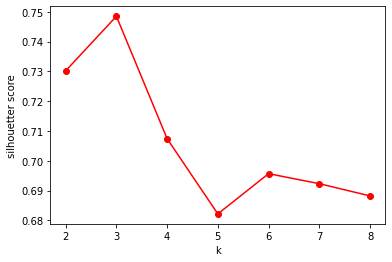

In [25]:
plt.plot(k_list, silhouette_list, 'ro-')
plt.xlabel('k')
plt.ylabel('silhouetter score')
plt.show()

**Nhận xét:** 
Số cụm tốt nhất mà Kmean thể hiện qua thông số sihouette là 3 với chỉ số là 0.75 . Ta tiến hành phân cụm dữ liệu theo 3 cụm và tiến hành phân tích, trích xuất đặc điểm mỗi cụm theo keywords.

In [26]:
#Thực hiện phân cụm với k = 3
kmeans = KMeans(k = 3,seed=42)
model = kmeans.fit(clean_data)
predictions = model.transform(clean_data)

In [27]:
predictions.select('text','prediction').show()

+--------------------+----------+
|                text|prediction|
+--------------------+----------+
|Canadian pharmaci...|         0|
|The Yukon governm...|         0|
|The Senate late W...|         2|
|Scientists around...|         0|
|    Trudeau says ...|         2|
|The continued exi...|         2|
|Recent developmen...|         2|
|Michigan hospital...|         0|
|The number of con...|         2|
|The Jewish Genera...|         0|
| Three Saskatchew...|         2|
|A Manitoba chiefs...|         0|
|This column is an...|         2|
|Construction is o...|         2|
|Alberta's TV and ...|         0|
|The first wave hi...|         2|
|A Memorial Univer...|         0|
|Manitoba is under...|         1|
|Medical experts a...|         2|
|New Brunswick has...|         2|
+--------------------+----------+
only showing top 20 rows



In [28]:
predictions.groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         2| 1102|
|         0| 2432|
|         1|   32|
+----------+-----+



### Display clusters by Word Cloud

In [29]:
from wordcloud import WordCloud, STOPWORDS

In [30]:
true_k = 3
df = []
for i in range(true_k):
    content=[]
    cluster_k = predictions.select('stop_tokens').where(col('prediction') == i)
    for n in range(cluster_k.count()):
        content = np.concatenate((content,cluster_k.collect()[n][0]))
    df.append([i,content])
df = pd.DataFrame(df,columns=['Cluster','Content'])

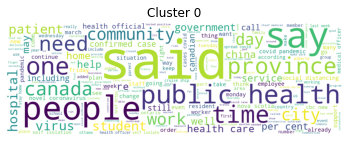

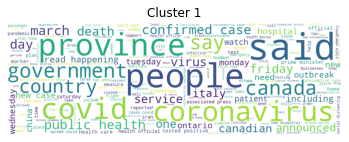

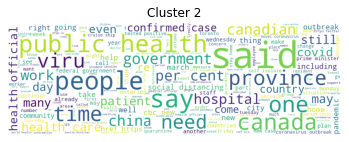

In [31]:
for i in range(df.shape[0]):
    wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(df.iloc[i,1]))
    plt.imshow(wordcloud)
    plt.title('Cluster ' + np.str(i))
    plt.axis('off')
    plt.grid(False)
    plt.show()
    

**Nhận xét:**
Khi sử dụng toàn bộ dữ liệu và số lượng từ để mô tả tính chất từng cụm thông qua WordCloud, ta chỉ có thể biết được rằng các cụm đều đang nói về covid19 mà không thấy rõ sự khác nhau mỗi cụm 

**Giải pháp:**
Tiến hành trích xuất 50 từ xuất hiện nhiều nhất của mỗi cụm để loại bỏ những từ gây nhiễu.

In [33]:
key_words = []
for i in range(3):
  temp =  predictions.where(col('prediction') == i).\
          select(explode('stop_tokens')).\
          groupby(col('col')).\
          count().\
          sort(col('count').desc())
  bag_words = temp.select('col').toPandas().col.tolist()
  key_words.append(bag_words)

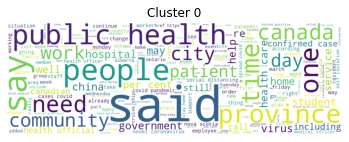

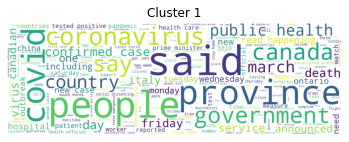

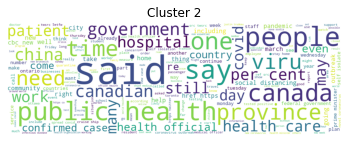

In [34]:
for i in range(3):
  values_words = []
  content = predictions.where(col('prediction') == i).\
            select(explode('stop_tokens')).\
            toPandas().col.tolist()
  for word in content:
    if word in key_words[i]:
      values_words.append(word)
    else:
      pass
  wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(values_words))
  plt.imshow(wordcloud)
  plt.title('Cluster ' + np.str(i))
  plt.axis('off')
  plt.grid(False)
  plt.show()

**Nhận xét :**
Dựa vào 50 từ xuất hiện nhiều nhất của mỗi cụm để phân tích, ta có thể thấy tính chất các cụm vẫn chưa được rõ ràng. Nhiều keywords xuất hiện ở cả 3 cụm với tần số cao.

**Giải pháp:**
Cần tiến hành sàng lọc các từ xuất hiện ở cả 3 cụm để chiết xuất những đặc trưng cụ thể hơn ở mỗi cụm thay vì những cụm từ thông dụng, xuất hiện nhiều nhưng không đặc tả được ý nghĩa từng cụm.

In [100]:
intersection_words = set.intersection(*map(set,key_words))


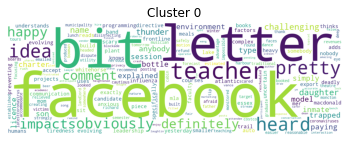

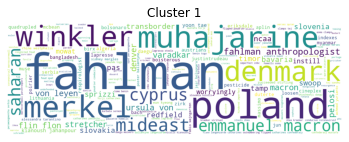

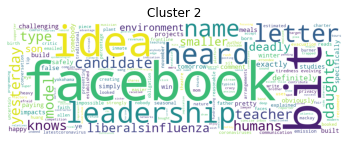

In [101]:
for i in range(3):
  values_words = []
  content = predictions.where(col('prediction') == i).\
            select(explode('stop_tokens')).\
            toPandas().col.tolist()
  for word in content:
    if (word in key_words[i]) & (word not in intersection_words):
      values_words.append(word)
    else:
      pass
  wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(values_words))
  plt.imshow(wordcloud)
  plt.title('Cluster ' + np.str(i))
  plt.axis('off')
  plt.grid(False)
  plt.show()

**Nhận xét:**

Việc loại bỏ những từ nằm ở cả 3 cụm đã giúp thấy rõ Cluster 1 thiên về từ khóa chính trị,tên các nhà lãnh đạo, chính trị gia, tên quốc gia xuất hiện nhiều cho thấy cụm 1 có xu hướng viết về nạn dịch covid19 và nỗ lực ngăn chăn của các quốc gia với sự dẫn dắt cũng như chính sách của những người đứng đầu nhà nước.

 Cluster 0 và 2 vẫn có nhiều nét tương đồng khi cùng nhắc nhiều đến các cụm từ về mạng xã hội nói chung. Ta tiếp tục phân tích, lọc bỏ những cụm từ cùng xuất hiện ở cluster 0 và 2 để hiểu rõ hơn sự khác biệt giữa hai cụm này. 


In [104]:
#intersection_02 = set(key_words[0]).intersection(key_words[2])
intersection_02 = ['facebook','bit','heard','letter']

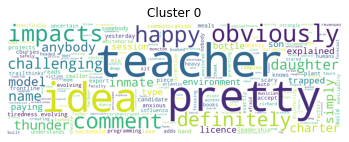

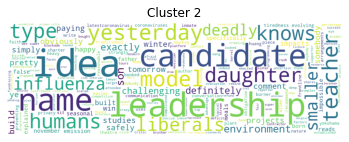

In [105]:
for i in [0,2]:
  values_words = []
  content = predictions.where(col('prediction') == i).\
            select(explode('stop_tokens')).\
            toPandas().col.tolist()
  for word in content:
    if (word in key_words[i]) & (word not in intersection_words) & (word not in intersection_02):
      values_words.append(word)
    else:
      pass
  wordcloud = WordCloud(background_color = 'white', width = 1200, height = 400).generate(' '.join(values_words))
  plt.imshow(wordcloud)
  plt.title('Cluster ' + np.str(i))
  plt.axis('off')
  plt.grid(False)
  plt.show()

**Nhận xét:**

- Sau khi lọc riêng các cụm từ chung của 2 cụm 0 và 2 ta nhận thấy như sau:
  + Cluster 0 chứa nhiều tính từ mang tính chất cảm thán như pretty, happy, definely, obviously, bên cạnh đó có những keywords như teacher, daughter, anybody nên có thể cụm này thuộc về mảng cộng đồng(community)
  + Cluster 2 thể hiện thiên về chính trị(poverment), bầu cử, lãnh đạo và ý tưởng.